shape of the first reading file  (200,)
number of allocating array  for data is  (8000, 200)
number of models 1001
number of models 2001
number of models 3001
number of models 4001
number of models 5001
number of models 6001
number of models 7001
loaded shapes for input and output (8000, 200) (8000, 200)


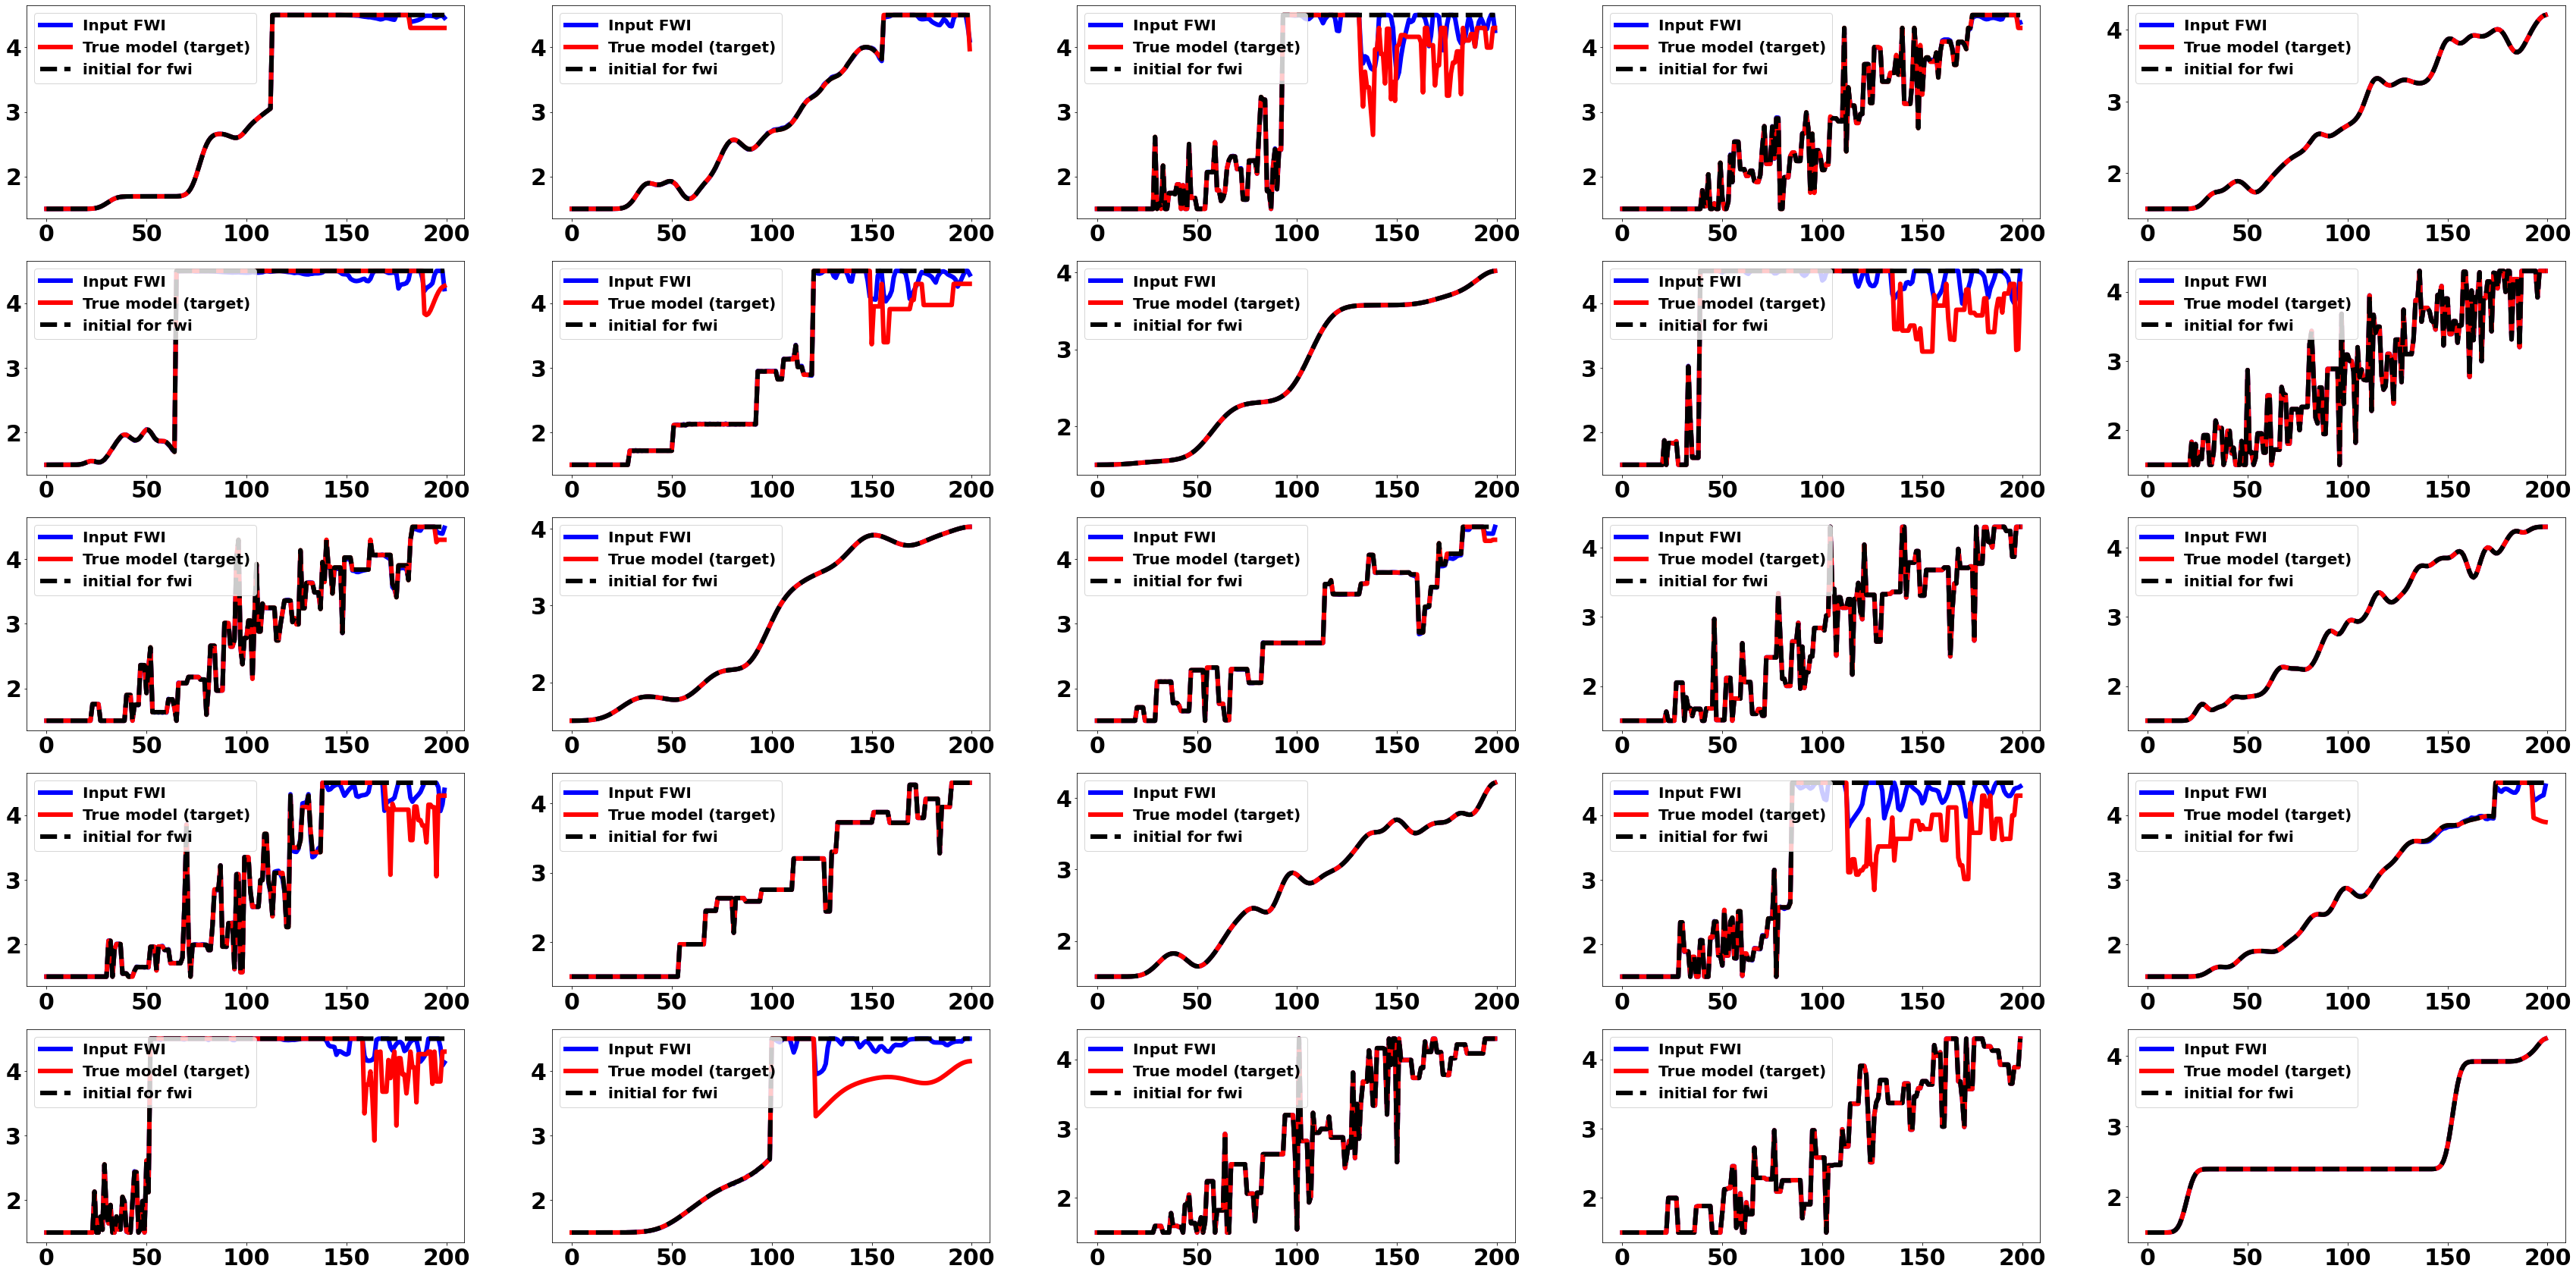

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
from prep_data import Dataset
import torch
from torch import autograd
from torch.utils.data import DataLoader
from unet import UNet
import torch.nn as  nn
import random
from scipy.ndimage.filters import gaussian_filter1d
from util import plot_models1D, plot_models1D, plot_history, scale_data, plot_models1D2, plot_r2
from noise_layer import GaussianNoise
import time 



def r2_score(target, prediction):
    """Calculates the r2 score of the model
    
    Args-
        target- Actual values of the target variable
        prediction- Predicted values, calculated using the model
        
    Returns- 
        r2- r-squared score of the model
    """
    r2 = 1- torch.sum((target-prediction)**2) / torch.sum((target-target.float().mean())**2)
    return r2


def run_training(model,opt,criterion,training_data,valid_data,num_epoch=100,batchsz=32):
	ntrain = training_data.x_data.shape[0]
	nvalid = valid_data.y_data.shape[0]
	train_loader= DataLoader (dataset=training_data,batch_size=batchsz,shuffle=True)
	valid_loader= DataLoader(dataset=valid_data,batch_size=batchsz,shuffle=True)
	loss_train = []
	loss_valid = []
	R2_train = []
	R2_valid = []
	t_start = time.time()
	add_noise = GaussianNoise(0.01) # This is a noise layer, used for regularization only for training, changing the standard deviation might change the output
	for epoch in range (num_epoch):
		epoch_train_loss=0
		R2_train_running=0
		# loop over batches
		for batch,data in enumerate (train_loader,0):
			inputs,targets = data
			# inputs = inputs.view(inputs.shape[0],1,inputs.shape[1])
			targets = targets.view(targets.shape[0],1,targets.shape[1])
			inputs = add_noise(inputs)
			pred = model(inputs)
			loss = criterion(pred,targets) 
			R2_train_running += r2_score(targets,pred)
			epoch_train_loss += loss.item()
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()
		epoch_train_loss = epoch_train_loss/(ntrain/batchsz)
		R2_train_running = R2_train_running/(ntrain/batchsz) 

		with torch.no_grad():
			epoch_valid_loss=0 
			R2_valid_running=0
			for batch,data in enumerate (valid_loader,0):
				inputs,targets = data
				targets = targets.view(targets.shape[0],1,targets.shape[1])
				pred = model(inputs)
				loss = criterion(pred,targets)
				R2_valid_running += r2_score(targets,pred)
				epoch_valid_loss += loss.item()
			epoch_valid_loss = epoch_valid_loss/(nvalid/batchsz)
			R2_valid_running = R2_valid_running/(nvalid/batchsz) 

		loss_train.append(epoch_train_loss)
		loss_valid.append(epoch_valid_loss)	
		R2_train.append(R2_train_running)
		R2_valid.append(R2_valid_running)
		print(f'''epoch: {epoch+1:3}/{num_epoch:3}  Training_loss: {epoch_train_loss:.5e}  Validation_loss: {epoch_valid_loss:.5e}
		 R2_Training: {R2_train_running:.5}  R2_Validation: {R2_valid_running:.5}''')
	t_end = time.time()
	print("=================================================")
	print(f"Training time is {(t_end-t_start)/60} minutes.")
	print("=================================================")

	return model,np.array(loss_train),np.array(loss_valid),np.array(R2_train),np.array(R2_valid)






# =====================================================
if __name__ == '__main__':
	# Hyperpar
	batchsz= 32
	LR = 0.001
	num_epoch =  100
	chanl = 16

	# reading the inputs and targets
	# path1 = './output_ibx4/' # Arbitrary mean 
	path1 = './output_ibx5/' # BP mean 

	# path1 = './output/samples/'
	ifile = 1
	endfile= 8000

	# Read the first file 
	inp2=np.load(path1+'inv_m'+str(ifile)+'.npy') 
	oup2 =np.load(path1+'true_m'+str(ifile)+'.npy')
	init2 =np.load(path1+'init_m'+str(ifile)+'.npy')
	print('shape of the first reading file ',init2.shape)
	# netname = 'unet2' # EAGE abstract 
	# netname = 'unet3' # train with bp_mean using 5 in_channel  
	netname = 'unet4'  # train with bp_mean

	# Allocate the arrays 
	nm = inp2.shape[0]
	nt = inp2.shape[1]
	inp = np.zeros((endfile,nt))
	oup = np.zeros((endfile,nt))
	init = np.zeros((endfile,nt))
	print('number of allocating array  for data is ',init.shape)
	inp[0,:] = inp2
	oup[0,:] = oup2
	init[0,:] = init2
	for k in range(ifile,endfile):
		inp_tmp = np.load(path1+'inv_m'+str(k)+'.npy')
		oup_tmp = np.load(path1+'true_m'+str(k)+'.npy')
		init_tmp = np.load(path1+'init_m'+str(k)+'.npy')
		inp[nm,:] = inp_tmp
		oup[nm,:] = oup_tmp
		init[nm,:] = init_tmp
		nm +=1
		if k%1000==0:print('number of models', nm)       
	
	print ('loaded shapes for input and output',inp.shape, oup.shape)	
	path1 = './output/'
	plot_models1D2(inp,oup,init,inp.shape[0],5,5)

In [3]:
	# inp = np.repeat(inp.reshape((inp.shape[0],1,inp.shape[1])),repeats=5,axis=1)
	# init = np.repeat(init.reshape((init.shape[0],1,init.shape[1])),repeats=5,axis=1)
	inp = inp.reshape((inp.shape[0],1,inp.shape[1]))
	init = init.reshape((init.shape[0],1,init.shape[1]))
	inp = np.concatenate((inp,init),axis=1)

In [4]:
	# Normalize the data 
	inp = inp/4.5
	oup = oup/4.5
	init = init/4.5
#	oup = gaussian_filter1d(oup,sigma=2,axis=-1)

	#plot_models1D(inp,oup,inp.shape[0],5,5)

	# split training and validation
	x_train,x_valid, y_train, y_valid = train_test_split(inp,oup, test_size=0.2)
	ntrain = x_train.shape[0]
	nvalid = x_valid.shape[0]


	# np.save(path1+'NNmodel/xtrain2',x_train) # EAGE Abstract 
	# np.save(path1+'NNmodel/ytrain2',y_train) # EAGE Abstract 
	# np.save(path1+'NNmodel/xvalid2',x_valid) # EAGE Abstract 
	# np.save(path1+'NNmodel/yvalid2',y_valid) # EAGE Abstract 	

	np.save(path1+'NNmodel/xtrain_%s'%netname,x_train)
	np.save(path1+'NNmodel/ytrain_%s'%netname,y_train)
	np.save(path1+'NNmodel/xvalid_%s'%netname,x_valid)
	np.save(path1+'NNmodel/yvalid_%s'%netname,y_valid)




In [5]:
	print('shape of the training data is ', x_train.shape)
	print('number of training: ',ntrain )
	print('number of validation: ',nvalid )
	print('Batch: ',batchsz )

	# prepare data for pytorch loader
	training_data=Dataset(x_train,y_train)
	valid_data =Dataset(x_valid,y_valid)


	# define NN model
	model = UNet(in_channels=2,out_channels=1,init_features=chanl)
	# model = UNet(in_channels=10,out_channels=1,init_features=chanl) # For this use unference 2
	model.cuda()
	# this should be outer loop
	optimizer = torch.optim.Adam(model.parameters(), lr=LR)
	criterion = nn.MSELoss() 

	# Run trainnig 
	model, loss_train, loss_valid, r2_train,r2_valid = run_training(model,optimizer,criterion,training_data,valid_data,num_epoch)


	torch.save(model.state_dict(),path1+'NNmodel/'+netname)

shape of the training data is  (6400, 2, 200)
number of training:  6400
number of validation:  1600
Batch:  32
epoch:   1/100  Training_loss: 4.31740e-03  Validation_loss: 7.80092e-04
		 R2_Training: 0.92578  R2_Validation: 0.98657
epoch:   2/100  Training_loss: 6.47111e-04  Validation_loss: 5.78306e-04
		 R2_Training: 0.98892  R2_Validation: 0.99001
epoch:   3/100  Training_loss: 4.97876e-04  Validation_loss: 4.82718e-04
		 R2_Training: 0.9915  R2_Validation: 0.99164
epoch:   4/100  Training_loss: 4.56171e-04  Validation_loss: 4.76787e-04
		 R2_Training: 0.99216  R2_Validation: 0.99175
epoch:   5/100  Training_loss: 5.10982e-04  Validation_loss: 4.08909e-04
		 R2_Training: 0.99122  R2_Validation: 0.99292
epoch:   6/100  Training_loss: 4.06617e-04  Validation_loss: 4.02509e-04
		 R2_Training: 0.99301  R2_Validation: 0.99298
epoch:   7/100  Training_loss: 3.82390e-04  Validation_loss: 3.87190e-04
		 R2_Training: 0.99343  R2_Validation: 0.99331
epoch:   8/100  Training_loss: 3.74949e-04 

Done training yaaaaaay --------


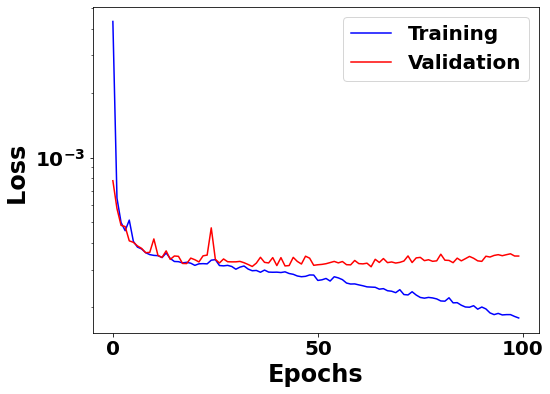

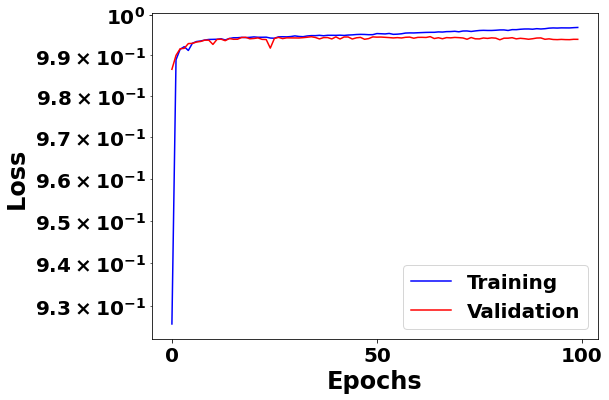

In [6]:
	# np.save(path1+'NNmodel/Training_loss',np.array(loss_train))      # EAGE 
	# np.save(path1+'NNmodel/Validation_loss',np.array(loss_valid)) # EAGE 
	# np.save(path1+'NNmodel/Training_R2',np.array(r2_train)) # EAGE 
	# np.save(path1+'NNmodel/Validation_R2',np.array(r2_valid)) # EAGE 


	np.save(path1+'NNmodel/Training_loss'+netname,np.array(loss_train))     
	np.save(path1+'NNmodel/Validation_loss'+netname,np.array(loss_valid))
	np.save(path1+'NNmodel/Training_R2'+netname,np.array(r2_train))
	np.save(path1+'NNmodel/Validation_R2'+netname,np.array(r2_valid))
	plot_history(loss_train,loss_valid,netname) # you have to plt.show() or otherse it just save the plot 
	plot_history(r2_train,r2_valid,netname) # you have to plt.show() or otherse it just save the plot 
	print('Done training yaaaaaay --------')

